## Boundary value problems

In the last segment we covered the integration of ordinary differential equations from initial conditions specified at one value of the independent variable (initial value problems). Frequently, however, the relevant physics dictate that boundary conditions be applied at more than one value of the independent variable. ODEs constitute "two-point boundary value problems" (BVPs) when boundary (or interface) conditions need to be applied at at least two values of the independent variable. BVPs most commonly involve boundary conditions applied at the beginning and ending values of the integration domain. There are many approaches to solving BVPs, and usually the best one to take depends on the details your problem. 

### Shooting method

Shooting methods build on the machinery for solving IVPs that we've already covered. Generally, an $N$'th order differential equation requires $N$ boundary conditions. If $n_i$ of those are specified at the first boundary $x_i$, then $n_f=N-n_i$ must be applied at the second boundary $n_f$. In a shooting method, we apply $n_i$ boundary conditions and additionally $n_f$ guesses for the remaining conditions at $x_i$. Integrating ("shooting") to $x_f$, we then check whether the $n_f$ boundary conditions at $x_f$ are satisfied. If they are not, we adjust our guesses at $x_i$ and start again.

The integration of the ODEs can itself be thought of as a function, where $n_f$ inputs at the initial boundary (our guesses for the unspecified conditions) produce $n_f$ outputs (the degree to which the remaining BCs are satisfied at $x_f$). To solve the BVP, we can therefore apply root-finding algorithms like the Newton-Raphson iteration that we covered a few segments ago. The relevant vector formulation of Newton's method is

\begin{equation}
    {\bf J}\cdot\delta\vec{\bf v} = -\vec{\bf f},
\end{equation}

where $\vec{\bf f}$ is a vector of $n_f$ deviations from the required boundary conditions at $x_f$, $\delta\vec{\bf v}$ is a correction to a vector $\vec{\bf v}$ of $n_f$ "guesses" applied at $x_i$, and ${\bf J}$ is a Jacobian matrix: $J_{ij}=\partial f_i/\partial v_j$. In the case $n_f=1$, this formulation simplifies to the same formula we used for root-finding earlier on.

### Application

Let's use a shooting method to solve the differential equation

\begin{equation}
    \frac{\partial^2 y}{\partial x^2}
    -(x^6 + 3x^2)y = 0,
\end{equation}

subject to the boundary conditions $y(-1)=y(1)=1$. The analytical solution to this BVP is $y(x)=\exp[(x^4-1)/4]$. The following code applies a shooting method with Newton-Raphson iteration to this equation (restructured in terms of auxiliary variables $y_1=y,$ $y_2=y'$):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import solve

plt.rcParams.update({'font.size':16})

def shootNR(iterfun,v0,maxits=100,eps=1e-8,tol=1e-12):
    '''
        uses a shooting method with Newton iteration to solve BVPs
        
            iterfun:    function that implements a single integration given 
                        guesses at initial conditions/unspecified parameters.
                        assumed to take array of parameters varied at first 
                        integration point, and return both (i) the integrated 
                        solution and (ii) an array of deviations from the desired 
                        BCs at final integration point
            ic0:        array-like. initial guess at parameters varied 
    '''
    # array of conditions varied:
    v = np.array(v0)
    Nv= len(v)
    
    # iterate
    itr = 0
    conv= False
    while itr<maxits:
        print(f'iteration {itr}:')
        
        # primary integration for this iteration
        sol,f = iterfun(v)
        
        # check for convergence:
        err = np.sum(abs(f))
        print('err=',err)        
        if err<tol:
            print(f'solution converged after {itr} iterations')
            conv = True
            break
        
        # compute Jacobian by perturbing each parameter varied:
        J = np.zeros([Nv,Nv])
        for j in range(Nv):
            dl = np.zeros([Nv])
            dl[j] = 1.
            df = iterfun(v + eps*dl)[1] - iterfun(v - eps*dl)[1]
            J[:,j] = df/2/eps
            
        # calculate correction to parameter vector:
        dv = solve(J,-f)
        v += dv
        print('dv=',dv)
        itr+= 1 
        
    # warning for unconverged solutions
    if conv==False:
        print(f'solution did not converge after {itr} iterations')
    return sol

iteration 0:
err= 0.0003539591136374476
dv= [-0.00011765]
iteration 1:
err= 4.0263126166451e-11
dv= [-1.33822537e-11]
iteration 2:
err= 9.103828801926284e-15
solution converged after 2 iterations


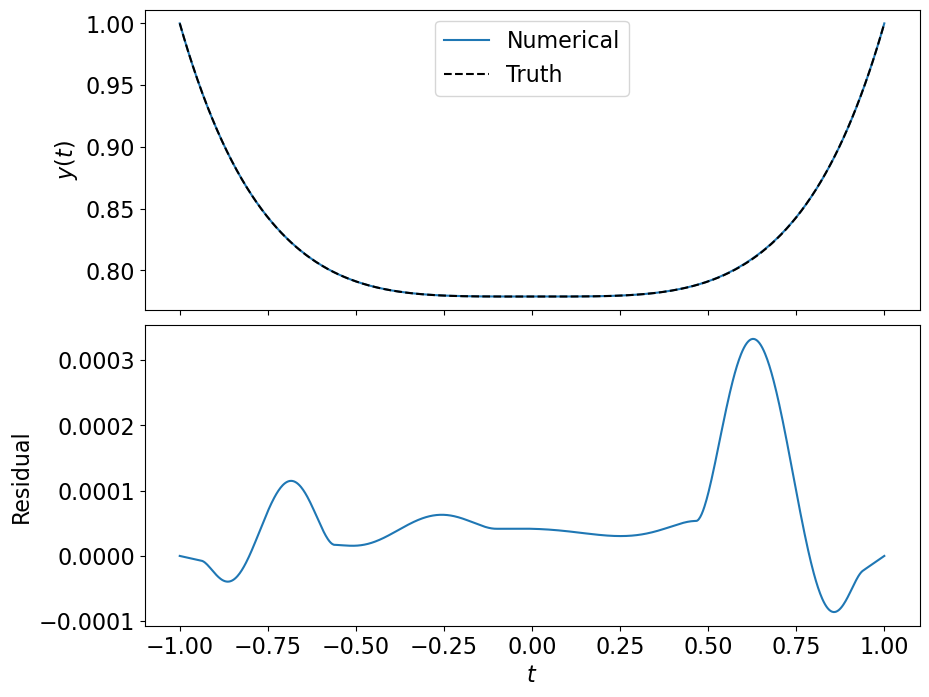

In [2]:
# apply the above to the BVP y'' + (x^6 + 3*x^2)*y = 0, y(-1)=y(1)=1:
def rhs(x,y):
    return [y[1],(x**6 + 3*x**2)*y[0]]

# define grid-points for evaluation and exact answer:
x = np.linspace(-1,1,1000)
ans = np.exp((x**4 - 1)/4.)

# define function to pass to shootNR:
def iterfun(v):
    sol = solve_ivp(fun=rhs,y0=[1.,*v],t_span=[-1,1],t_eval=x)
    f = np.array([sol.y[0][-1]-1.])
    return sol,f 

# compute result:
sol = shootNR(iterfun,v0=[-1.])

# plot results:
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
ax[0].plot(sol.t,sol.y[0],label='Numerical')
ax[0].plot(x,ans,'k--',label='Truth')
ax[1].plot(x,sol.y[0]-ans)
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend()
plt.subplots_adjust(hspace=0.05)

## Exercise 7

With Newton iteration, we aren't limited to varying boundary conditions. Apply the above to solve for solutions to the eigenvalue problem describing a harmonic oscillator on a periodic domain:

\begin{equation}
    \frac{\text{d}^2y}{\text{d}x^2}
    +k^2y=0,
    \hspace{2em}
    y(0)=y(2\pi)=0, y'(0)=y'(2\pi).
\end{equation}

The solutions are $\sin(kx),$ where $k=1,2,3,...$.

# Matrix methods

Although Newton iteration can be powerful, shooting methods involving IVP solvers are very brittle; for stiff problems, initial guesses that are just a little bit off can send the solution flying in the wrong direction. Frequently, BVPs and in particular eigenvalue problems can be more naturally solved by applying linear algebra to discretized, matrix representations of the differential equation. 

As a first example, let's apply centred finite differences to the above oscillator equation $-k^2 y = y''.$ This can be discretized and written as the matrix equation $\lambda\vec{\bf y}={\bf A}\cdot\vec{\bf y},$ where $\lambda=-k^2,$ $\vec{\bf y}=[y_0,y_1,...,y_{N-1}]^T=[y(x_0),y(x_1),...,y(x_{N-1})]^T$ is the solution vector evaluated on the $N$ grid-points $x_0,...,x_{N-1}$, and ${\bf A}$ is a matrix representation of the differential operator $\partial^2_{xx}$. Recall from one of our earlier exercises that with centred finite differences,

\begin{equation}
    y''(x)\simeq\frac{1}{h^2}[y(x + h) -2y(x) + y(x - h)],
\end{equation}

where $h$ is the grid-spacing. The interior rows of ${\bf A}$ with indices $i>0$ and $i<N-1$ can then be computed from

\begin{equation}
    ({\bf A}\cdot\vec{\bf y})_i
    =\frac{1}{h^2}(y_{i+1} - 2y_i + y_{i-1}). 
\end{equation}

The remaining rows $i=0$ and $i=N-1$ can be used to encode the two boundary conditions for this second-order differential equation. Let's construct this discretized representation of the differential operator:

Text(0.5, 0, 'Columns')

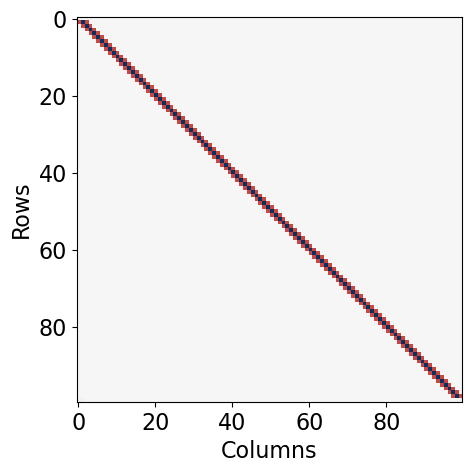

In [3]:
N = 100
x = np.linspace(0,2*np.pi,N)
h = x[1]-x[0]

# this construction can also be done more efficiently with vector operations, using np.diag
A = np.zeros([N,N])
for i in range(1,N-1):
    A[i,i-1]= 1./h/h
    A[i,i]  =-2./h/h
    A[i,i+1]= 1./h/h
B = np.eye(N) # RHS matrix in eqn of form A.dot(y)=lm*B.dot(y)

# now we encode the boundary condition that y[0]=0:
A[0,0] = 1.
B[0,:] = 0

# # and lastly that y'[0] - y'[-1] = 0:
A[-1,0] =-1./h
A[-1,1] = 1./h
A[-1,-2]= 1./h
A[-1,-1]=-1./h
B[-1,:]  = 0

# visualize the matrix:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(A,cmap='RdBu_r',vmin=-1.5/h/h,vmax=1.5/h/h)
ax.set_ylabel('Rows')
ax.set_xlabel('Columns')

Solving for the eigenmodes then simply reduces to a call to scipy's wrapper for standard linear algebra libraries:

(0.999832175162285-0j)
(1.998657604073377-0j)
(2.9954705541979383-0j)
(3.989267319390046-0j)


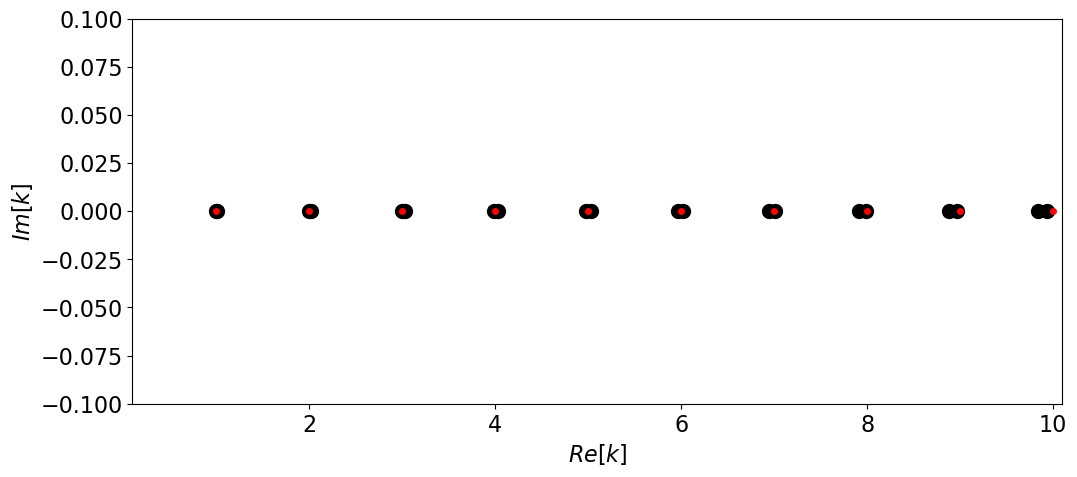

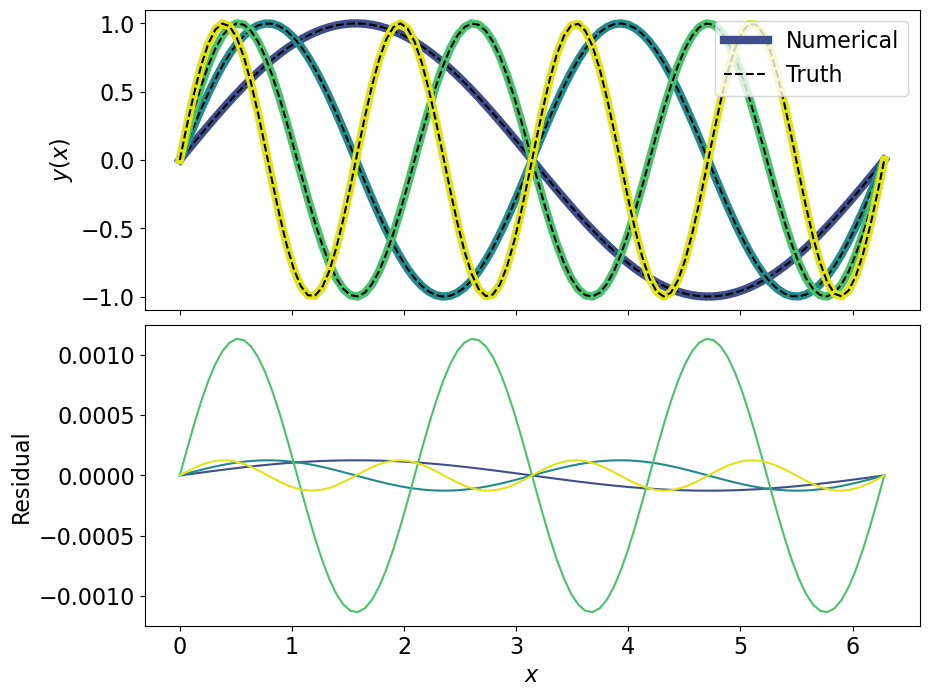

In [5]:
from scipy.linalg import eig

# compute eigenmodes
w,y = eig(A,B)
k = np.sqrt(-w)

# plot eigenfrequencies:
f,ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(k.real,k.imag,'ko',ms=10)
ax.plot(np.arange(1,11),[0 for i in range(1,11)],'ro',ms=4)
ax.set_ylim([-.1,.1])
ax.set_xlim([0.1,10.1])
ax.set_xlabel('$Re[k]$')
ax.set_ylabel('$Im[k]$')

# plot solutions:
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
cols = plt.cm.viridis(np.linspace(0,.95,5))
for kk in range(1,5):
    idx = np.argmin(abs(k - kk))
    print(k[idx])
    soly= y[:,idx]*np.sign(y[1,idx])
    soly= soly/np.amax(abs(soly))
    ans = np.sin(kk*x)
    ax[0].plot(x,soly,label='Numerical' if kk==1 else '__nolegend__',color=cols[kk],lw=6)
    ax[0].plot(x,ans,'k--',label='Truth' if kk==1 else '__nolegend__')
    ax[1].plot(x,soly-ans,color=cols[kk])

ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$y(x)$')
ax[1].set_ylabel('Residual')
ax[0].legend()
plt.subplots_adjust(hspace=0.05)

If you play around with the solutions here, you will find that this calculation returned additional eigenvectors/values outside on top of the ones we were looking for. This is a significant downside to matrix methods for solving BVPs: diagonalizing an $N\times N$ matrix will produce $N$ eigenvectors/values, and many of these may spurious/non-physical solutions to the discretized system of algebraic equations but not the underlying differential equation.

## Exercise

The accuracy we achieved above can be improved dramatically. Using the $2N$ grid-points $x_i=i\pi/N$, $i=0,...,2N-1$, replace the matrix ${\bf A}$ above with ${\bf D}$, where

\begin{equation}
    D_{ij}
    =\begin{cases}
        -(1 + 2N^2)/6, & i=j \\
        0.5(-1)^{i - j + 1}/\sin^2[0.5(x_i - x_j)], & i\not=j
    \end{cases}
\end{equation}

Try computing the same solutions $\sin(kx)$, replacing only the first row with the boundary condition $y_0=0$. Compare the errors from these calculations to those achieved with finite differences above. For more on this, see Boyd 2001 (http://www-personal.umich.edu/~jpboyd/BOOK_Spectral2000.html)